In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dateutil
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
data = pd.read_csv("../../dataset/KAG_energydata_complete.csv")

<Axes: ylabel='appliances'>

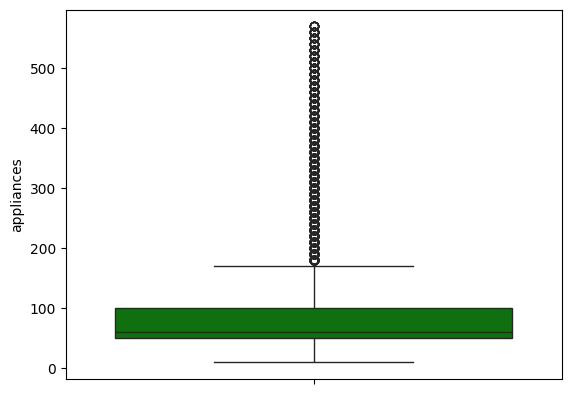

In [4]:
data.columns = [x.lower() for x in data.columns]
data = data[data['appliances'].between(data['appliances'].quantile(.0), data['appliances'].quantile(.99))]

sns.boxplot(data["appliances"],color="green")

In [5]:
data["exact_date"] = data['date'].str.split(' ').str[0]
data["hours"] = (data['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)
data["seconds"] = ((data['date'].str.split(':').str[1])).astype(str).astype(int).mul(60)

data["week"] = (data['date'].str.split(' ').str[0])
data["week"] = (data['week'].apply(dateutil.parser.parse, dayfirst=True))
data["weekday"] = (data['week'].dt.dayofweek).astype(str).astype(int)
data["week"] = (data['week'].dt.day_name())

data['log_appliances'] = np.log(data.appliances)
data['hour*lights'] = data.hours * data.lights
data['hour_avg'] = list(map(dict(data.groupby('hours')["appliances"].mean()).get, data.hours))

data.head(5)

,date,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,...,rv1,rv2,exact_date,hours,seconds,week,weekday,log_appliances,hour*lights,hour_avg
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,13.275433,13.275433,2016-01-11,17,0,Tuesday,1,4.094345,510,141.919699
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,18.606195,18.606195,2016-01-11,17,600,Tuesday,1,4.094345,510,141.919699
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,28.642668,28.642668,2016-01-11,17,1200,Tuesday,1,3.912023,510,141.919699
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,45.410389,45.410389,2016-01-11,17,1800,Tuesday,1,3.912023,680,141.919699
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,10.084097,10.084097,2016-01-11,17,2400,Tuesday,1,4.094345,680,141.919699


In [6]:
# Data sets in 30 minitues and 1 hour basis
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
numeric_cols = data.select_dtypes(include=[np.number]).columns
df_hour = data[numeric_cols].resample('1H').mean()
df_30min = data[numeric_cols].resample('30min').mean()

/tmp/ipykernel_154939/3536861094.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = data[numeric_cols].resample('1H').mean()


In [7]:
# Qualitative predictors 
'''We assume that we have low(high) energy load when the appliances consumption is lower(higher) 
   than a given point of the hourly average counsumption. This point is dependent of data time frequency 
   and the numbers below are set after several tryouts based on appliances' consumption standard deviation.
'''

data['low_consum'] = (data.appliances + 25 < (data.hour_avg)) * 1
data['high_consum'] = (data.appliances + 100 > (data.hour_avg)) * 1

df_hour['low_consum'] = (df_hour.appliances + 25 < (df_hour.hour_avg)) * 1
df_hour['high_consum'] = (df_hour.appliances + 25 > (df_hour.hour_avg)) * 1

df_30min['low_consum'] = (df_30min.appliances + 25 < (df_30min.hour_avg)) * 1
df_30min['high_consum'] = (df_30min.appliances + 35 > (df_30min.hour_avg)) * 1

In [8]:
for cat_feature in ['weekday', 'hours']:
    df_hour = pd.concat([df_hour, pd.get_dummies(df_hour[cat_feature])], axis=1)
    df_30min = pd.concat([df_30min, pd.get_dummies(df_30min[cat_feature])], axis=1)
    df = pd.concat([data, pd.get_dummies(data[cat_feature])], axis=1)

# Modelling

In [9]:
feature_set = ['low_consum', 'high_consum', 'hours', 't6', 'rh_6', 'lights', 'hour*lights',
               'tdewpoint', 'visibility', 'press_mm_hg', 'windspeed']

In [10]:
# to avoid warnings from standardscaler
df_hour.lights = df_hour.lights.astype(float)
df_hour.log_appliances = df_hour.log_appliances.astype(float)
df_hour.hour = df_hour.hours.astype(float)
df_hour.low_consum = df_hour.low_consum.astype(float)
df_hour.high_consum = df_hour.high_consum.astype(float)

/tmp/ipykernel_154939/2665868572.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_hour.hour = df_hour.hours.astype(float)


In [11]:
# Creation of train/test sets
test_size = .2
test_index = int(len(df_hour.dropna()) * (1 - test_size))

X_train, X_test = df_hour[feature_set].iloc[:test_index,], df_hour[feature_set].iloc[test_index:,]
y_train = df_hour.log_appliances.iloc[:test_index,]
y_test = df_hour.log_appliances.iloc[test_index:,]

In [12]:
from sklearn.preprocessing import StandardScaler

# Normalizing of X matrices for each model to mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=800, min_samples_leaf=10, min_samples_split=5,
                                 n_estimators=60, random_state=1)         
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=800, min_samples_leaf=10, min_samples_split=5,
                      n_estimators=60, random_state=1)

In [14]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict

# Function to evaluate the models
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    # Inverse transform predictions (because target is log-transformed)
    predictions = np.exp(predictions)
    test_labels = np.exp(test_labels)

    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_labels, predictions)

    print(model, '\n')
    print('Mean Absolute Error (MAE): {:0.4f}'.format(mae))
    print('Mean Squared Error (MSE): {:0.4f}'.format(mse))
    print('Root Mean Squared Error (RMSE): {:0.4f}'.format(rmse))
    print('R-squared: {:0.2f}%'.format(r2))

In [15]:
evaluate(rf_model, X_test_scaled, y_test)

RandomForestRegressor(max_depth=800, min_samples_leaf=10, min_samples_split=5,
                      n_estimators=60, random_state=1) 

Mean Absolute Error (MAE): 20.5519
Mean Squared Error (MSE): 1367.7684
Root Mean Squared Error (RMSE): 36.9834
R-squared: 0.55%


In [16]:
# Final predictions (unscaled)
y_best_pred = rf_model.predict(X_test_scaled)
y_best_pred_unscaled = np.exp(y_best_pred)

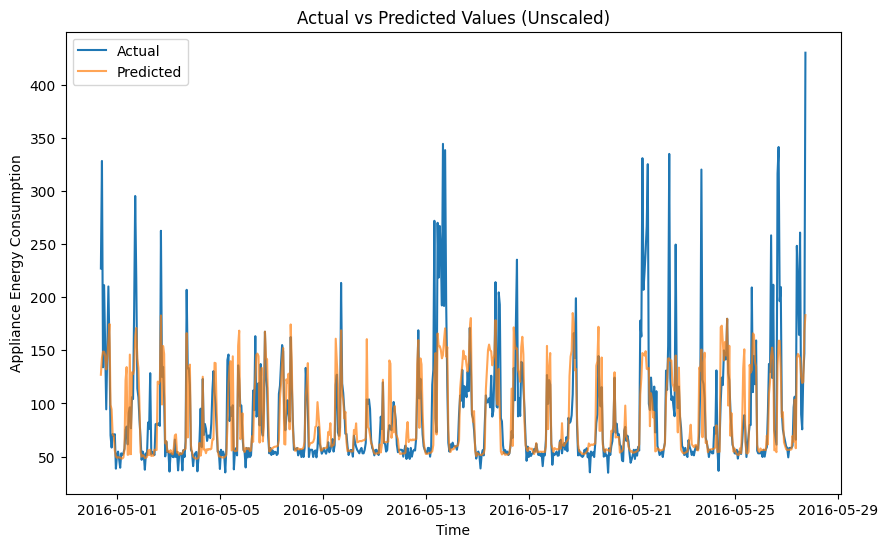

In [17]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_hour.index[test_index:], np.exp(y_test), label='Actual')
plt.plot(df_hour.index[test_index:], y_best_pred_unscaled, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values (Unscaled)')
plt.xlabel('Time')
plt.ylabel('Appliance Energy Consumption')
plt.legend()
plt.show()